<a href="https://colab.research.google.com/github/manulon/TP2Simulacion/blob/main/Simulacion_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
!pip install colorama
from colorama import init, Fore, Back, Style
from scipy.integrate import odeint
plt.style.use("bmh")
!pip install simpy
import simpy


#Ejercicio 1 

Simule el siguiente problema.
Se está diseñando un web service, el cual cada vez que es invocado consulta a una base de datos.
El tiempo que transcurre entre cada llamada al servicio se puede modelar según una distribución exponencial con media 𝜇
Considerar 𝜇 = 1, 2 𝑦 4 𝑠𝑒𝑔𝑢𝑛𝑑𝑜𝑠

Alternativa 1

Se utilizan 2 bases de datos distribuidas.
Con probabilidad 𝑝 = 0.6 las solicitudes son atendidas por la base A y con probabilidad 𝑞 = 1 − 𝑝 son atendidos por la
base de datos B.
El tiempo que demora cada base de datos en atender una solicitud sigue una distribución exponencial con medias,
𝜇1 = 0,7 𝑠𝑒𝑔 y 𝜇2 = 0,95 𝑠𝑒𝑔 respectivamente.

Alternativa 2

Utilizar 1 base de datos central.
En este caso la demora en resolver una solicitud sigue una distribución exponencial con 𝜇 = 0,8 𝑠𝑒𝑔𝑢𝑛𝑑𝑜𝑠


Realizar 100 simulaciones de cada modelo, con 100000 solicitudes procesadas, y determinar:

El tiempo medio de espera entre que la solicitud llega y puede ser procesada (suponer que ninguna conexión se
cae por timeout).

La fracción de las solicitudes que no esperaron para ser procesadas.

La tasa de finalización de consultas (consultas finalizadas por segundo)

¿Qué solución le recomienda? Justifique

In [7]:
BASE1 = 0
BASE2 = 1

def dividirMuestrasPorBase(tiemposMuestras, p):
    tiemposMuestrasPorBase = {}
    tiemposMuestrasPorBase[BASE1] = []
    tiemposMuestrasPorBase[BASE2] = []

    for muestra in tiemposMuestras:
        u = np.random.rand()
        if u < p:
            base = BASE1
        else:
            base = BASE2

        tiemposMuestrasPorBase[base].append(muestra)

    return tiemposMuestrasPorBase

def calcularDemora(tiemposMuestras, tiemposEspera, n):
    tiemposEsperaFinal = np.zeros(n)
    tiempoDeEsperaAnterior = 0
    j = 1
    while j < n:
        deltaT = tiemposMuestras[j] - tiemposMuestras[j - 1] - tiempoDeEsperaAnterior
        tiempoDeEspera = tiemposEspera[j - 1] - deltaT
        if tiempoDeEspera <= 0:
            tiempoDeEspera = 0
        tiemposEsperaFinal[j] = tiempoDeEspera
        tiempoDeEsperaAnterior = tiempoDeEspera
        j += 1
    return tiemposEsperaFinal

def calcularDemoraB1(tiemposMuestras, mu1, mu2, p, n):
    muestrasPorBase = dividirMuestrasPorBase(tiemposMuestras, p)
    tiemposMuestrasB1 = muestrasPorBase[BASE1]
    tiemposMuestrasB2 = muestrasPorBase[BASE2]

    tiemposEsperaB1 = np.random.exponential(mu1, len(tiemposMuestrasB1))
    demoraBase1 = calcularDemora(
        tiemposMuestrasB1, tiemposEsperaB1, len(tiemposMuestrasB1)
    )

    tiemposEsperaB2 = np.random.exponential(mu2, len(tiemposMuestrasB2))
    demoraBase2 = calcularDemora(
        tiemposMuestrasB2, tiemposEsperaB2, len(tiemposMuestrasB2)
    )

    tiemposEspera = np.concatenate((tiemposEsperaB1, tiemposEsperaB2))
    demoraAlternativa1 = np.concatenate((demoraBase1, demoraBase2))

    return tiemposEspera, demoraAlternativa1

n = 100000
mumuestras = []
mumuestras.append(0.5)
mumuestras.append(1)
mumuestras.append(2)
mumuestras.append(4)
prob_solicitud_base_a = 0.6
muB1_1 = 0.7        # Prom tiempo primera base datos
muB1_2 = 0.95       # Prom Tiempo segunda base datos
muCaso2 = 0.8       # Prom Tiempo segunda alternativa

for i in mumuestras:
  
  # Genero tiempos de llamadas
  z_llamadas = np.random.exponential(i, n)
  tiemposLlamadas = np.concatenate(([0], np.cumsum(z_llamadas)), axis=None)

 
  # Demoras caso 1
  tiemposC1, demoraCaso1 = calcularDemoraB1(tiemposLlamadas, muB1_1, muB1_2, prob_solicitud_base_a, n)

  # Demoras caso 2
  tiemposC2 = np.random.exponential(muCaso2, n)
  
  demoraCaso2 = calcularDemora(tiemposLlamadas, tiemposC2, n)
    
  promedioDemoraCaso1 = demoraCaso1.mean()
  promedioDemoraCaso2 = demoraCaso2.mean()


  cantidadSinEsperarA1 = n - np.count_nonzero(demoraCaso1)
  fraccionCantidadSinEsperarA1 = cantidadSinEsperarA1/n
  cantidadSinEsperarA2 = n - np.count_nonzero(demoraCaso2)
  fraccionCantidadSinEsperarA2 = cantidadSinEsperarA2/n
  
  
  # tiempoTotalC1 = sum(demoraCaso1.tolist() + z_llamadas.tolist())
  tiempoTotalC1 = tiemposLlamadas[-1] + demoraCaso1[-1] + tiemposC1[-1]
  tasaFinalizacionCaso1 = n/tiempoTotalC1
  tiempoTotalC2 = tiemposLlamadas[-1] + demoraCaso2[-1] + tiemposC2[-1]
  # tiempoTotalC2 = sum(demoraCaso2.tolist() + z_llamadas.tolist())
  tasaFinalizacionCaso2 = n/tiempoTotalC2

  
  print("\n-----------------\n")
  print("Se esta usando mu = ", i)
  print("N = ", n, "\n")


  print("Alternativa 1:")
  print("el tiempo total en horas es {:.4f} ".format(tiempoTotalC1 /3600))
  print("El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es {:.3f} ".format(promedioDemoraCaso1))

  print(
    "El tiempo medio de espera es de: {:.3f} segundos".format(promedioDemoraCaso1)
  )
  print(
    "La fraccion de las solicitudes que no esperaron es: {:.3f}\n".format(fraccionCantidadSinEsperarA1))

  print("La tasa de finalizacion de consultas es: {:.3f}\n".format(tasaFinalizacionCaso1))

  print("Alternativa 2:")
  print("el tiempo total en horas es {:.4f} ".format(tiempoTotalC2/3600) )
  print("El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es {:.3f} ".format(promedioDemoraCaso2))
  print(
    "El tiempo medio de espera es de: {:.3f} segundos".format(promedioDemoraCaso2)
  )
  print(
    "La fraccion de las solicitudes que no esperaron es: {:.3f}\n".format(fraccionCantidadSinEsperarA2))

  print("La tasa de finalizacion de consultas es: {:.3f} \n".format(tasaFinalizacionCaso2))



-----------------

Se esta usando mu =  0.5
N =  100000 

Alternativa 1:
el tiempo total en horas es 13.8546 
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 3.635 
El tiempo medio de espera es de: 3.635 segundos
La fraccion de las solicitudes que no esperaron es: 0.189

La tasa de finalizacion de consultas es: 2.005

Alternativa 2:
el tiempo total en horas es 22.2853 
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 15083.223 
El tiempo medio de espera es de: 15083.223 segundos
La fraccion de las solicitudes que no esperaron es: 0.000

La tasa de finalizacion de consultas es: 1.246 


-----------------

Se esta usando mu =  1
N =  100000 

Alternativa 1:
el tiempo total en horas es 27.8849 
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 0.525 
El tiempo medio de espera es de: 0.525 segundos
La fraccion de las solicitudes que no esperaron es: 0.599

La tasa de finali

#Ejercicio 2

Replicar los resultados del trabajo “A Markov Chain Model for Covid-19 Survival Analysis”

 Implementar las soluciones planteadas en el trabajo en las secciones 2.0 A Simple Markov Chain y 3.0 A More
Complex Markov Chain.

Realizar las visualizaciones que consideren necesarias para mostrar los resultados.

Para la cadena de Markov propuesta en cada sección mostrar la evolución de 10 individuos a lo largo del tiempo
(100 días)

 Para una población de 10.000 individuos, grafique las curvas de evolución de cada uno de los estados aplicando las
cadenas de Markov propuestas por el trabajo. 

### A) Seccion 2.0: A Simple Markov Chain


En este caso se consideran tres estados: 0: Paciente sano. 1: Paciente infectado. 2: Paciente hospitalizado
El paciente no puede pasar de sano a hospitalizado, o viceversa, sin pasar por el estado infectado. El paciente
puede mantenerse en el mismo estado.
A su vez se tiene una matriz P donde se modela la matriz de transición de probabilidad de Markov 

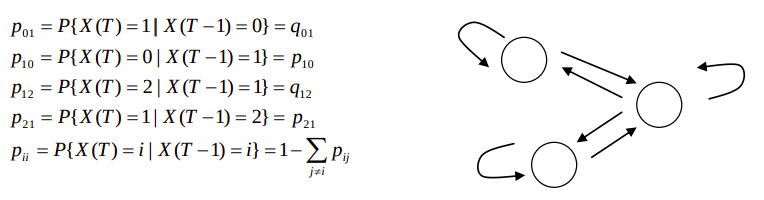

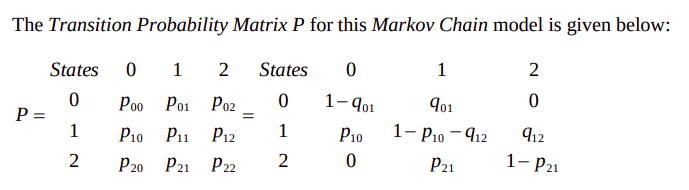

Contamos con dos sistemas de Markov, uno llamado eficiente y uno llamado no eficiente. El paper nos comenta
y nos permite ver que el sistema eficiente, a la larga en el tiempo, mantiene una mayoria de pacientes sanos
y pocos hospitalizados. Mientras que en el sistema ineficiente se mantienen relativamente pocos sanos y muchos 
mas hospitalizados.

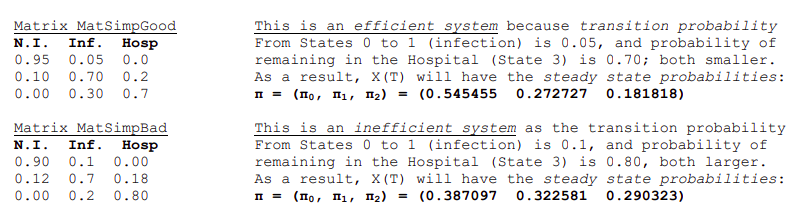

Tambien podemos ver que en el sistema eficiente, el tiempo promedio entre dos pacientes hospitalizados es mucho
mayor al tiempo promedio entre dos pacientes sanos. En el sistema ineficiente estos valores son mucho mas parecidos
entre si, lo cual logicamente seria preocupante.

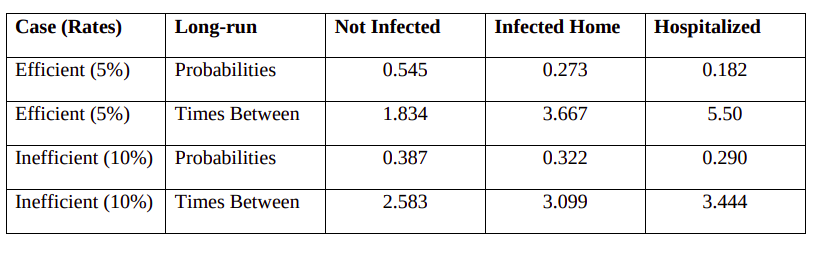

La diferencia fundamental entre los sistemas es que en el eficiente la probabilidad de mantenerse sano es 
de 95% mientras que en el eficiente es del 90%, y en el eficiente la probabilidad de seguir en el hospital
es de "solo" el 70% mientras que en el ineficiente es del 80%

In [ ]:
''' ARMAMOS LA MATRIZ DE PROBABILIDADES '''
eficiente = {"p00" : 0.95, "p01" : 0.05, "p02" : 0,
			"p10": 0.10, "p11" : 0.70, "p12" : 0.2,
			"p20": 0, "p21": 0.30, "p22": 0.7}

ineficiente = {"p00" : 0.9, "p01" : 0.1, "p02" : 0,
			"p10": 0.12, "p11" : 0.70, "p12" : 0.18,
			"p20": 0, "p21": 0.2, "p22": 0.8}		

In [ ]:
def estado_futuro(sistema,a,b):
	future = random.random()
	if (sistema[a] > future):
		return "Sano"
	elif (sistema[a] + sistema[b]) < future:
		return "Hospitalizado" 
	else:
		return "Infectado"

def cambiar_estado(estado_actual, sistema):
	a = ""
	b = ""
	if (estado_actual == "Sano"):
		a = "p00"
		b = "p01"
	elif (estado_actual == "Infectado"):
		a = "p10"
		b = "p11"
	else:
		a = "p20"
		b = "p21"
	return estado_futuro(sistema,a,b)

def sistema_verificacion(N,sistema):
	#Contamos la cantidad de tiempos que el paciente pasa en cada estado
	#Con un número suficientemente grande podemos aproximar el vector Pi

	estados = [1,0,0]
	estado = "Sano" #arrancamos en paciente sano
	for_graph = []
	for i in range(N):
		estado = cambiar_estado(estado,sistema)
		if (estado == "Sano"):
			estados[0] += 1
			for_graph.append("Sano")
		elif (estado == "Infectado"):
			estados[1] += 1
			for_graph.append("Infectado")
		else:
			estados[2] += 1
			for_graph.append("Hospitalizado")
	
	
	print("Se muestra el porcentaje de tiempo que pasa el paciente en cada estado en regimen:")
	print("El porcentaje de sanos es " + str((estados[0]/N) * 100) + "%")
	print("El porcentaje de infectados es " + str((estados[1]/N) * 100) + "%")
	print("El porcentaje de hospitalizados es " + str((estados[2]/N) * 100) + "%")

	print("")

	print("Se muestra el tiempo promedio entre dos visitas sucesivas a cada estado:")
	print("T0 (Sanos): " + str(1/(estados[0]/N)))
	print("T1 (Infectados) " + str(1/(estados[1]/N)))
	print("T2 (Hospitalizados) " + str(1/(estados[2]/N)))
	print("")
	'''
	Obtenemos practicamente el resultado del paper para el sistema '''

	#Se muestran graficos para visualizar los resultados
	y = ["Sano","Infectado","Hospitalizado"]
	plt.ylabel('Cantidad')
	plt.xlabel('Estado')
	plt.title("Cantidad de veces en cada estado")
	plt.bar(y,estados)
	plt.show()
'''
	plt.title("Estado por unidad de tiempo")
	plt.xlabel("Tiempo")
	plt.ylabel("Estado")
	plt.plot(for_graph)
	plt.show()
'''

def evolucion_sistema(sistema):
	#Estado inicial sano
	estado = "Sano"
	for i in range(10): #10 individuos
		print(Fore.WHITE + "Persona numero: " + str(i))
		print(Fore.GREEN + estado, end="")
		for j in range(100): #100 instantes de tiempo
			estado = cambiar_estado(estado,sistema)
			if (estado == "Sano"):
				print(" -> " + Fore.GREEN + estado, end="")
			elif (estado == "Infectado"):
				print(" -> " + Fore.YELLOW + estado, end="")
			else:
				print(" -> " + Fore.RED + estado, end="")
		print("\n\n")
		estado = "Sano"

def curvas_evolucion(poblacion,sistema):
	dias = 100 #tomamos 100 dias para la evaluacion
	estado = "Sano" #estado inicial
	cantidad_sanos = []
	cantidad_infectados = []
	cantidad_hospitalizados = []
	y = []

	for dia in range(dias):
		cantidad_sanos.append(0)
		cantidad_infectados.append(0)
		cantidad_hospitalizados.append(0)
		y.append(dia)

	for i in range(poblacion):
		for j in range(dias):
			if (estado == "Sano"):
				cantidad_sanos[j] += 1
			elif (estado == "Infectado"):
				cantidad_infectados[j] += 1
			else:
				cantidad_hospitalizados[j] += 1
			estado = cambiar_estado(estado,sistema)
		estado = "Sano"
		
	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado Sano por dia")
	plt.plot(y,cantidad_sanos)
	plt.show()

	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado Infectado por dia")
	plt.plot(y,cantidad_infectados)
	plt.show()

	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado Hospitalizado por dia")
	plt.plot(y,cantidad_hospitalizados)
	plt.show()


SISTEMA EFICIENTE:

Se muestra el porcentaje de tiempo que pasa el paciente en cada estado en regimen:
El porcentaje de sanos es 54.4897%
El porcentaje de infectados es 27.2909%
El porcentaje de hospitalizados es 18.2195%

Se muestra el tiempo promedio entre dos visitas sucesivas a cada estado:
T0 (Sanos): 1.8352092230274715
T1 (Infectados) 3.664225071360783
T2 (Hospitalizados) 5.488624825050084



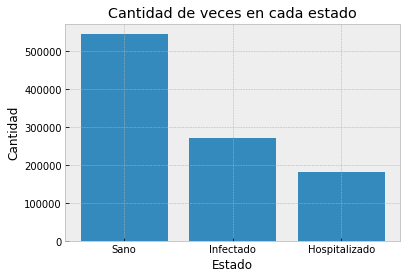

In [ ]:
#PUNTOS A Y B
N = 1000000 #iteraciones
print("SISTEMA EFICIENTE:")
print("")
sistema_verificacion(N,eficiente)

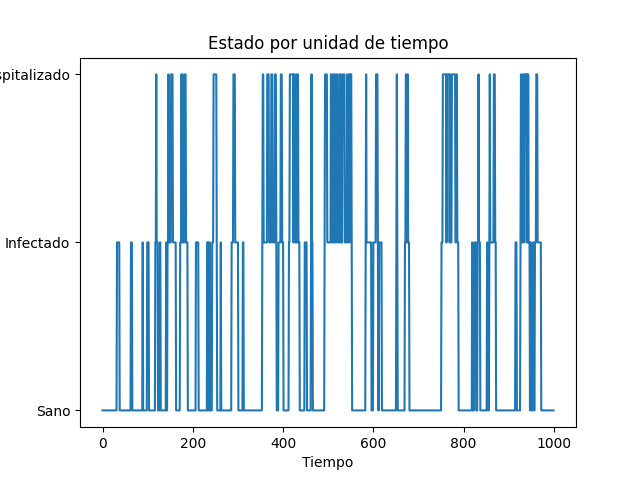

SISTEMA INEFICIENTE:

Se muestra el porcentaje de tiempo que pasa el paciente en cada estado en regimen:
El porcentaje de sanos es 38.7911%
El porcentaje de infectados es 32.224000000000004%
El porcentaje de hospitalizados es 28.985%

Se muestra el tiempo promedio entre dos visitas sucesivas a cada estado:
T0 (Sanos): 2.577910912554684
T1 (Infectados) 3.103277060575968
T2 (Hospitalizados) 3.450060376056581



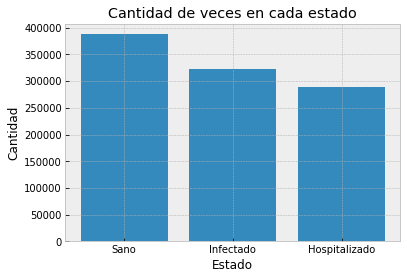

In [ ]:
	print("SISTEMA INEFICIENTE:")
	print("")
	sistema_verificacion(N,ineficiente)


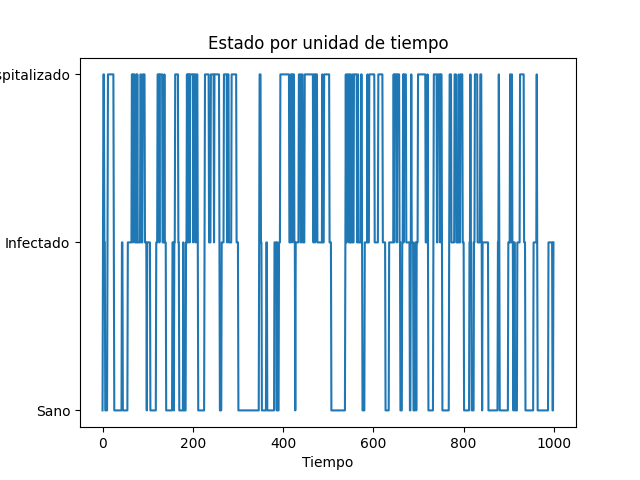

In [ ]:
#PUNTO C
evolucion_sistema(eficiente)


Persona numero: 0
Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Infectado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Infectado -> Inf

In [ ]:
evolucion_sistema(ineficiente)


Persona numero: 0
Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Sano -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Infectado -> Infectado -> Inf

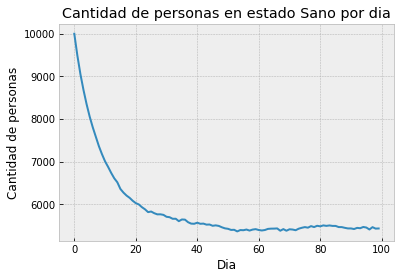

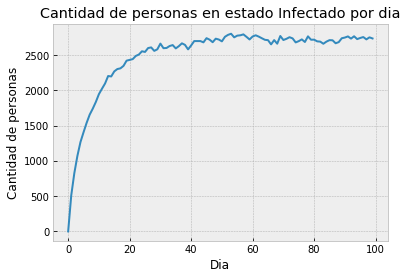

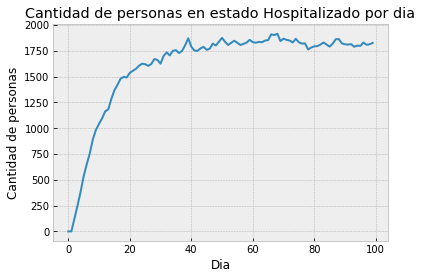

In [ ]:
#PUNTO D
curvas_evolucion(10000,eficiente)


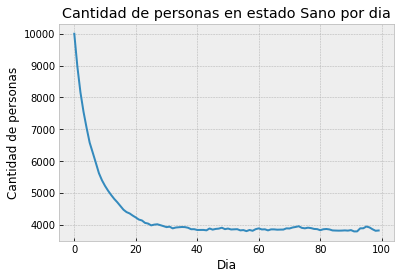

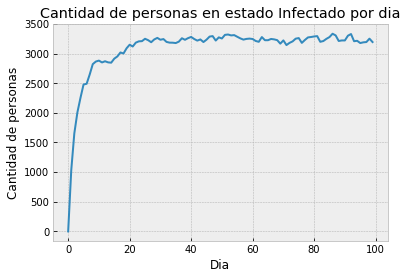

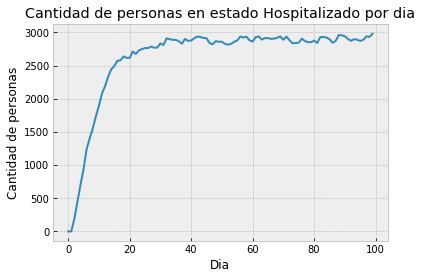

In [ ]:
curvas_evolucion(10000,ineficiente)


 ## Seccion 3.0: A More Complex Markov Chain

En este caso se consideran 5 estados: 0: Paciente sano. 1: Paciente infectado. 2: Paciente hospitalizado.
3: Paciente en ICU (Cuidados intensivos). 4: Dead (estado absorbente) 
Si el paciente cae en estado Dead, ya no puede salir del mismo, es un estado absorbente.

A su vez se tiene una matriz P donde se modela la matriz de transición de probabilidad de Markov.
Este modelo se considera mas realista y complejo, similar a las situaciones presentadas en Italia o
Nueva York en sus crisis de COVID 19.

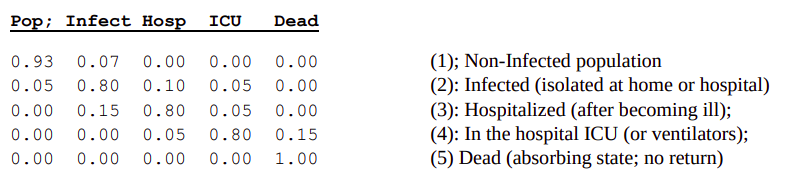

Este modelo, si no se aplica inmunidad de ningun tipo contra la enfermedad y si se aplican 
suficientes iteraciones de tiempo, invariablemente finalizara con la muerte de toda la población. 

En este caso, como invariablemente los pacientes van a morir, no tiene sentido buscar la solución
en estado estacionario, entonces lo que el paper nos muestra es la probabilidad de morir a largo plazo
y los tiempos esperados para morir, comenzando en los estados 1, 2, 3.
Para ello obtenemos una sub matriz de P, llamada Q, en la que se elimina la fila y columna del estado Dead,
y luego se invierte esta matriz (I-Q)**(-1).

El paper nos presenta una tabla donde se presenta el tiempo promedio hasta la muerte del paciente, partiendo
desde cada uno de los estados posibles.
Luego nos muestra una tabla de probabilidades de que un paciente muera en N dias empezando desde cualquiera
de los estados transitorios. Esto se calcula con la propiedad de Markov. Observamos que la probabilidad de morir
en menos de 16 dias es relativamente baja, siempre y cuando el paciente no entre en ICU.
Luego se calcula la matriz F, obteniendo la probabilidad de que una persona alcance algún estado de la Cadena
de Markov, especialmente el estado absorbente de morir, dado que dicha persona comienza en cualquiera 
de los estados anteriores. La matriz F muestra la importancia de evitar una alta tasa de infección a largo plazo.'''


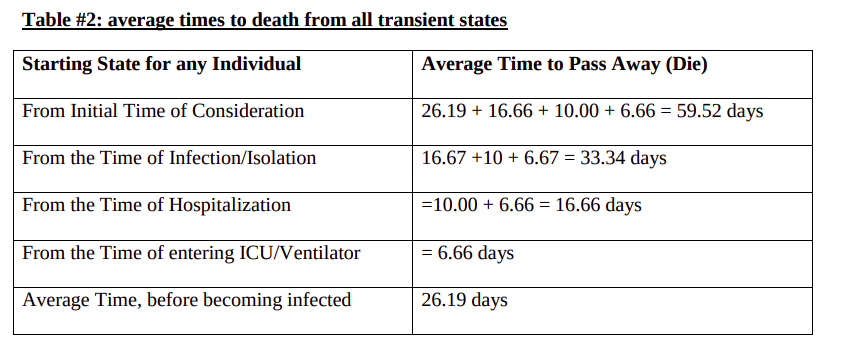

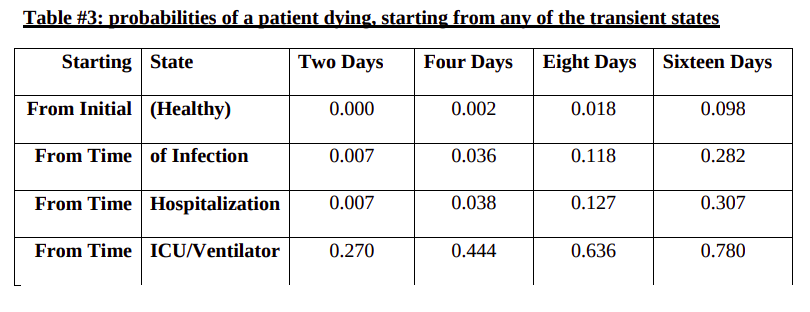

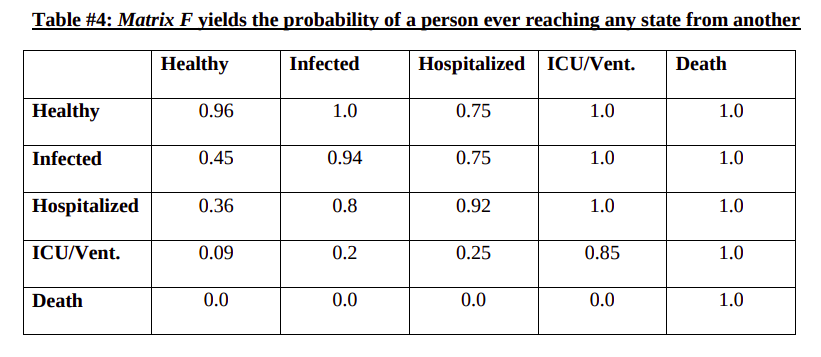

In [ ]:
''' ARMAMOS LA MATRIZ DE PROBABILIDADES '''
sistema = {"p00" : 0.93, "p01" : 0.07, "p02" : 0, "p03": 0, "p04": 0, 
		   "p10": 0.05 , "p11" : 0.80, "p12" : 0.1,"p13":0.05, "p14":0,
		   "p20": 0, "p21": 0.15, "p22": 0.8,"p23":0.05, "p24":0,
		   "p30": 0, "p31": 0, "p32": 0.05,"p33":0.80, "p34":0.15,
		   "p40": 0, "p41": 0, "p42": 0,"p43":0, "p44":1}

inversa = {
	"q00" : 26.1905, "q01" : 16.6667, "q02" : 10.0000, "q03" : 6.66667,
	"q10" : 11.9048, "q11" : 16.6667, "q12" : 10.0000, "q13" : 6.66667,
	"q20" : 9.5238, "q21" : 13.3333, "q22" : 13.3333, "q23" : 6.66667,
	"q30" : 2.3810, "q31" : 3.3333, "q32" : 3.3333, "q33" : 6.66667
}


In [ ]:
def sistema_verificacion(sistema,inversa):
	'''La matriz inversa contiene el número promedio de visitas a cada estado'''
	'''Al ser el estado Dead un estado absorbente nos interesa saber la cantidad
	de dias que se espera que pasen hasta llegar a el, partiendo desde cada uno de los
	estados'''
	'''El tiempo promedio antes de ser infectado es el indicado en la posicion (0,0)
	de la matriz inversa'''
	tinfectado = inversa["q00"]
	print("Tiempo promedio antes de infectarse: " + str(tinfectado) + " dias")

	'''Para obtener el tiempo promedio desde el estado Sano hasta dead sumamos todos
	los elementos de la primera fila'''
	tsanoamorir = inversa["q00"] + inversa["q01"] + inversa["q02"] + inversa["q03"]
	print("Tiempo promedio desde el estado Sano hasta morir: " +
		str(tsanoamorir) + " dias")

	'''De manera analoga calculamos el resto de las posibilidades''' 
	tinfectadoamorir = inversa["q01"] + inversa["q02"] + inversa["q03"]
	print("Tiempo promedio desde el estado Infectado hasta morir: " +
		str(tinfectadoamorir) + " dias")
	thospitalizadoamorir = inversa["q02"] + inversa["q03"]
	print("Tiempo promedio desde el estado Hospitalizado hasta morir: " +
		str(thospitalizadoamorir) + " dias")
	ticuamorir = inversa["q03"]
	print("Tiempo promedio desde el estado ICU hasta morir: " +
		str(ticuamorir) + " dias")
	print("")

	'''Ahora queremos calcular las probabilidades de que un paciente muera empezando en cualquiera
	de los estados, en una cantidad de dias definidos que son 2, 4, 8 y 16'''
	'''Esto se puede calcular con la propiedad de Markov: P**M = P * P * ... * P (M dias) '''

	'''Calculamos la probabilidad de llegar al estado Dead en 2 dias'''
	'''Para ello nos interesa calcular P**2 y mirar los valores de la ultima columna'''
	print("La probabilidad de morir en 2 dias desde estado Sano es: " +
		str(sistema["p00"] * sistema["p03"] + sistema["p01"] * sistema["p14"] 
		+ sistema["p02"] * sistema["p24"] + sistema["p03"] * sistema["p34"]
		+ sistema["p04"] * sistema["p44"]))

	print("La probabilidad de morir en 2 dias desde estado Infectado es: " +
		str(sistema["p10"] * sistema["p03"] + sistema["p11"] * sistema["p14"] 
		+ sistema["p12"] * sistema["p24"] + sistema["p13"] * sistema["p34"]
		+ sistema["p14"] * sistema["p44"]))

	print("La probabilidad de morir en 2 dias desde estado Hospitalizado es: " +
		str(sistema["p20"] * sistema["p03"] + sistema["p21"] * sistema["p14"] 
		+ sistema["p22"] * sistema["p24"] + sistema["p23"] * sistema["p34"]
		+ sistema["p24"] * sistema["p44"]))

	print("La probabilidad de morir en 2 dias desde estado ICU es: " +
		str(sistema["p30"] * sistema["p03"] + sistema["p31"] * sistema["p14"] 
		+ sistema["p32"] * sistema["p24"] + sistema["p33"] * sistema["p34"]
		+ sistema["p34"] * sistema["p44"]))
	
	'''Para calcular para los dias 4, 8 y 16 es el mismo procedimiento, se calcula 
	P**4 = P*P*P*P, P**8 = P*P*P*P*P*P*P*P, P**16 = P*P*P*P*P*P*P*P*P*P*P*P*P*P*P*P
	y luego se miran los valores de la ultima columna'''

	'''Vemos un grafico con el tiempo promedio hasta morir'''
	#Se muestran graficos para visualizar los resultados
	y = ["Sano","Infectado","Hospitalizado","ICU"]
	estados = [tsanoamorir, tinfectadoamorir, thospitalizadoamorir, ticuamorir]
	plt.ylabel('Cantidad de dias promedio')
	plt.xlabel('Estado inicial')
	plt.title("Dias promedio hasta morir")
	plt.bar(y,estados)
	plt.show()

	'''Analogamente vemos un grafico con la probabilidad de morir en 2 dias desde cada estado'''
	y = ["Sano","Infectado","Hospitalizado","ICU"]
	estados = [0, 0.0075, 0.0075, 0.27]
	plt.ylabel('Probabilidad')
	plt.xlabel('Estado inicial')
	plt.title("Probabilidad de morir en 2 dias partiendo de cada estado")
	plt.bar(y,estados)
	plt.show()

def estado_futuro(sistema,a,b,c,d):
	future = random.random()
	if (future < sistema[a]):
		return "Sano"
	elif (future < sistema[a] + sistema[b]):
		return "Infectado"
	elif (future < sistema[a] + sistema[b] + sistema[c]):
		return "Hospitalizado"
	elif (future < sistema[a] + sistema[b] + sistema[c] + sistema[d]):
		return "ICU"
	else:
		return "Dead"

def cambiar_estado(estado_actual, sistema):
	a = ""
	b = ""
	c = ""
	d = ""
	if (estado_actual == "Sano"):
		a = "p00"
		b = "p01"
		c = "p02"
		d = "p03"
	elif (estado_actual == "Infectado"):
		a = "p10"
		b = "p11"
		c = "p12"
		d = "p13"
	elif (estado_actual == "Hospitalizado"):
		a = "p20"
		b = "p21"
		c = "p22"
		d = "p23"
	elif (estado_actual == "ICU"):
		a = "p30"
		b = "p31"
		c = "p32"
		d = "p33"
	else:
		return "Dead"
	return estado_futuro(sistema,a,b,c,d)

def evolucion_sistema(sistema):
	#Estado inicial sano
	estado = "Sano"
	for i in range(10): #10 individuos
		print(Fore.WHITE + "Persona numero: " + str(i))
		print(Fore.GREEN + estado, end="")
		for j in range(100): #100 instantes de tiempo
			estado = cambiar_estado(estado,sistema)
			if (estado == "Sano"):
				print(" -> " + Fore.GREEN + estado, end="")
			elif (estado == "Infectado"):
				print(" -> " + Fore.YELLOW + estado, end="")
			elif (estado == "Hospitalizado"):
				print(" -> " + Fore.MAGENTA + estado, end="")
			elif (estado == "ICU"):
				print(" -> " + Fore.BLUE + estado, end="")
			else:
				print(" -> " + Fore.RED + estado, end="")
		print("\n\n")
		estado = "Sano"

def curvas_evolucion(poblacion,sistema):
	dias = 100 #tomamos 100 dias para la evaluacion
	estado = "Sano" #estado inicial
	cantidad_sanos = []
	cantidad_infectados = []
	cantidad_hospitalizados = []
	cantidad_icu = []
	cantidad_dead = []
	y = []

	for dia in range(dias):
		cantidad_sanos.append(0)
		cantidad_infectados.append(0)
		cantidad_hospitalizados.append(0)
		cantidad_icu.append(0)
		cantidad_dead.append(0)
		y.append(dia)

	for i in range(poblacion):
		for j in range(dias):
			if (estado == "Sano"):
				cantidad_sanos[j] += 1
			elif (estado == "Infectado"):
				cantidad_infectados[j] += 1
			elif (estado == "Hospitalizado"):
				cantidad_hospitalizados[j] += 1
			elif (estado == "ICU"):
				cantidad_icu[j] += 1
			else:
				cantidad_dead[j] += 1
			estado = cambiar_estado(estado,sistema)
		estado = "Sano"
		
	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado Sano por dia")
	plt.plot(y,cantidad_sanos)
	plt.show()

	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado Infectado por dia")
	plt.plot(y,cantidad_infectados)
	plt.show()

	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado Hospitalizado por dia")
	plt.plot(y,cantidad_hospitalizados)
	plt.show()

	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado ICU por dia")
	plt.plot(y,cantidad_icu)
	plt.show()

	plt.xlabel('Dia')
	plt.ylabel('Cantidad de personas')
	plt.title("Cantidad de personas en estado Dead por dia")
	plt.plot(y,cantidad_dead)
	plt.show()


Tiempo promedio antes de infectarse: 26.1905 dias
Tiempo promedio desde el estado Sano hasta morir: 59.52387 dias
Tiempo promedio desde el estado Infectado hasta morir: 33.33337 dias
Tiempo promedio desde el estado Hospitalizado hasta morir: 16.66667 dias
Tiempo promedio desde el estado ICU hasta morir: 6.66667 dias

La probabilidad de morir en 2 dias desde estado Sano es: 0.0
La probabilidad de morir en 2 dias desde estado Infectado es: 0.0075
La probabilidad de morir en 2 dias desde estado Hospitalizado es: 0.0075
La probabilidad de morir en 2 dias desde estado ICU es: 0.27


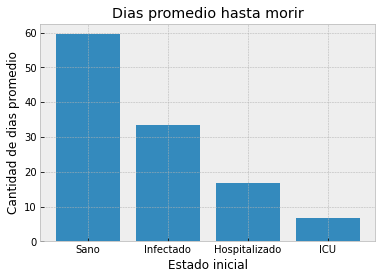

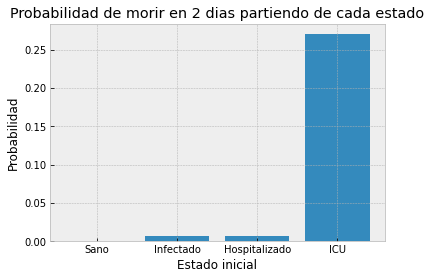

In [ ]:
#Puntos A y B
sistema_verificacion(sistema, inversa)


In [ ]:
#PUNTO C
evolucion_sistema(sistema)


Persona numero: 0
Sano -> Sano -> Sano -> Sano -> Sano -> Sano -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Hospitalizado -> Infectado -> Infectado -> ICU -> ICU -> ICU -> Dead -> Dead -> Dea

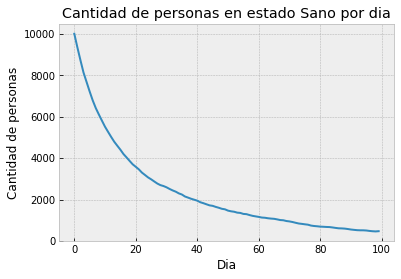

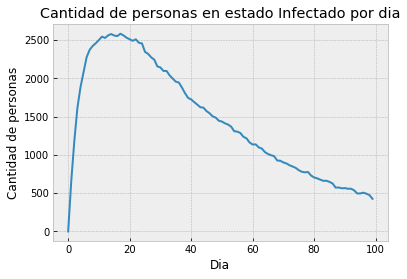

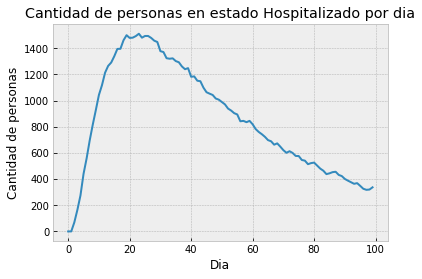

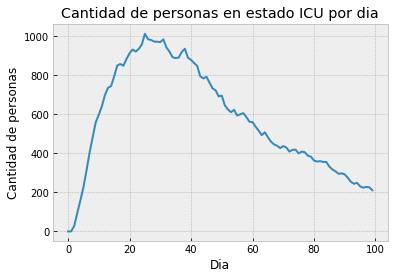

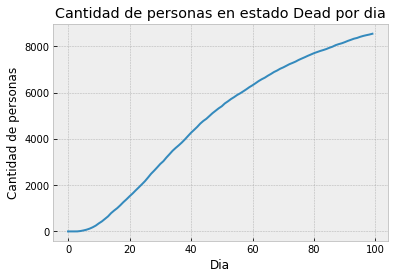

In [ ]:
#PUNTO D
curvas_evolucion(10000,sistema)

# Ejercicio 3
Se desea simular la evolución de una epidemia utilizando el modelo S.I.R.
Se conoce que inicialmente el 3% de la población se encuentra infectada, toda la población es susceptible de
contagiarse, la tasa de transmisión α=0,27, y la tasa de recuperación β = 0,043
Se pide:

Implementar el modelo SIR correspondiente.

Graficar las curvas de porcentajes de personas sanas, infectadas y recuperadas, de forma que se vea la evolución
de la epidemia.

Sabiendo que el sistema de salud puede asistir cómo máximo sólo al 30% de la población a la vez, determine la
duración total de la epidemia si se quiere que el pico máximo de infectados no supere las capacidades de
asistencia médica. ¿Qué parámetros modifica? ¿Por qué?

Pruebe con 3 distintos juegos de parámetros del modelo y comente los comportamientos explorados.
Compare estos resultados con los obtenidos en el Ejercicio 2.

Se desea simular la evolución de una epidemia utilizando el modelo S.I.R.
Se conoce que inicialmente el 3% de la población se encuentra infectada, toda la población es susceptible de
contagiarse, la tasa de transmisión α=0,27, y la tasa de recuperación β = 0,043

Modelo matemático SIR (contagio entre personas):

Tenemos tres variables y por ende tres ecuaciones diferenciales:

S(t): Susceptibles --> dS/dt = -alpha*S*I

I(t): Infectados --> dI/dt = alpha*S*I - beta*I

R(t): Recuperados --> dR/dt = beta*I


In [ ]:
# Las ecuaciones diferenciales del modelo SIR
def deriv(y, t, N, beta, alpha):
    S, I, R = y
    dSdt = -alpha*S*I/N
    dIdt = alpha*S*I/N - beta*I
    dRdt = beta*I
    return dSdt, dIdt, dRdt

def plot(S, I, R, t, divide_by):
    # Dibujamos los datos de S(t), I(t) y R(t)
    #fig, ax = plt.subplots()
    plt.plot(t, S/divide_by, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, I/divide_by, 'r', alpha=0.5, lw=2, label='Infectado')
    plt.plot(t, R/divide_by, 'g', alpha=0.5, lw=2, label='Recuperado')
    plt.axhline(y=0.30,linewidth=1,color='black',label='Max. cap. sistema de salud')
    plt.xlabel('Días')
    plt.ylabel('Cantidad de personas')
    plt.title("Cantidad de personas en cada estado por dia")
    legend = plt.legend()
    plt.show()

def modelo_sir(alpha,beta,poblacion,avgcontagiados):
	contagiados_inicial = avgcontagiados * poblacion
	s0 = poblacion - contagiados_inicial
	i0 = contagiados_inicial
	r0 = 0

	y0 = s0, i0, r0
	# Pasos temporales (en días)
	t = np.linspace(0, 200, 200)

	 #Integrate the SIR equations over the time grid, t.
	ret = odeint(deriv, y0, t, args=(poblacion, beta, alpha))
	S, I, R = ret.T

	plot(S, I, R, t, poblacion) # Datos normalizados

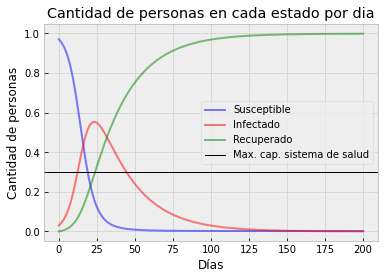

In [ ]:
alpha = 0.27
beta = 0.043
poblacion = 10000
modelo_sir(alpha,beta,poblacion,0.03)


Vemos que con este juego de datos se supera la capacidad maxima del sistema de salud,	queremos corregir esto.

Tenemos que modificar los parametros para lograr esto. Que significa cada parametro?

Alpha = Nos indica cuan facil es que un miembro de la población I infecte a un miembro de la población S.

Beta = El parámetro gamma nos indica la facilidad de que un miembro de la población I se recupere.

Entonces deberiamos reducir alpha y/o aumentar beta

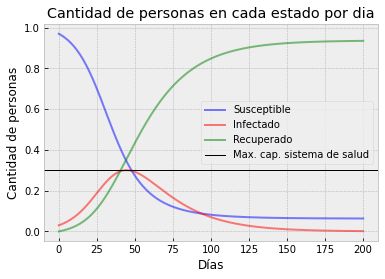

In [ ]:
alpha = 0.14
beta = 0.048
poblacion = 10000
modelo_sir(alpha,beta,poblacion,0.03)

De esta forma no se supera la capacidad del sistema de salud y la epidemia dura aprox. 175 dias

La pandemia dura mas dias pero el sistema de salud no colapsa. Si se quisiese que la pandemia dure lo menos posible, la capacidad del sistema de salud se veria excedida por mucho.


Cuanto tendriamos que modificar uno solo de los parametros para no saturar el sistema de salud?

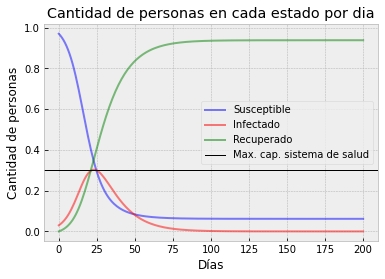

In [ ]:
alpha = 0.27
beta = 0.092
poblacion = 10000
modelo_sir(alpha,beta,poblacion,0.03)
#Aprox 85 dias

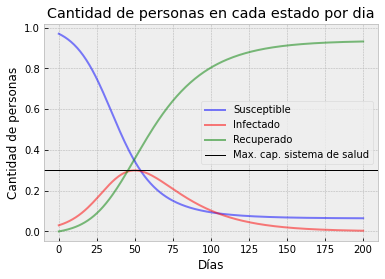

In [ ]:
alpha = 0.125
beta = 0.043
poblacion = 10000
modelo_sir(alpha,beta,poblacion,0.03)
#Aprox 200 dias

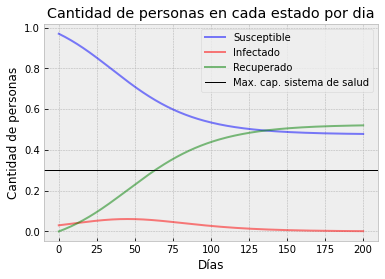

In [ ]:
'''Que pasa con los nuevos parametros de los ultimos dos sets?'''
alpha = 0.125
beta = 0.092
poblacion = 10000
modelo_sir(alpha,beta,poblacion,0.03)
#Aprox 150 dias pero muy pocos contagiados


Los resultados son similares al ejercicio 2 en cuanto a la velocidad y forma de las curvas para los contagios de la población, pero difieren en el momento de la recuperación de los pacientes, basicamente porque en el ejercicio 2 no obtenian inmunidad, por lo que cuando se llegaba a un pico de contagios se mantenia la curva ahi, e incluso morian, a diferencia de aqui que una vez curados 	se vuelven inmunes a la enfermedad, y no pueden morir. Entonces la curva de susceptibles/sanos si se	asemeja al ejercicio 2, pero la curva de infectados no lo hace, y tampoco la curva de recuperados	que no existia en el ejercicio anterior.

#Ejercicio 4

Implementar las dos alternativas del ejercicio 1 utilizando SimPy


## Alternativa 1 (Bases Distribuidas)

In [8]:
class llamada:
	def __init__(self,env,tiemposLlamadas):
		self.env = env
		self.demora = []
		self.call_proc = env.process(self.calcular_demora(tiemposLlamadas))

	def dividirMuestrasPorBase(self,tiemposMuestras):
		tiemposMuestrasPorBase = {}
		tiemposMuestrasPorBase[0] = []
		tiemposMuestrasPorBase[1] = []
		for muestra in tiemposMuestras:
			u = np.random.rand()
			if u < 0.6:
				base = 0
			else:
				base = 1
			tiemposMuestrasPorBase[base].append(muestra)
		return tiemposMuestrasPorBase

	def calcular_demora(self,tiemposMuestras):
		muestrasPorBase = self.dividirMuestrasPorBase(tiemposMuestras)
		tiemposMuestrasB1 = muestrasPorBase[0]
		tiemposMuestrasB2 = muestrasPorBase[1]

		tiemposEsperaB1 = np.random.exponential(0.7, len(tiemposMuestrasB1))
		demoraBase1 = self.env.process(self.llamar(tiemposMuestrasB1, tiemposEsperaB1, len(tiemposMuestrasB1)))		

		tiemposEsperaB2 = np.random.exponential(0.95, len(tiemposMuestrasB2))
		demoraBase2 = self.env.process(self.llamar(tiemposMuestrasB2, tiemposEsperaB2, len(tiemposMuestrasB2)))
		
		yield demoraBase2 & demoraBase1 #Bases distribuidas!!! Se ejecutan a la vez.

		print("El tiempo total en horas es: "+ str(env.now/3600))
		print("El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es {:.3f} ".format(self.demora.mean()))
		print("La fraccion de las solicitudes que no esperaron es: {:.3f}".format((100000 - np.count_nonzero(self.demora))/100000))
		print("La tasa de finalizacion de consultas por segundo es: {:.3f}\n".format(100000/(env.now)))

	def llamar(self,tiemposLlamadas,duracionLlamadas,n):
		tiemposEsperaFinal = np.zeros(n)
		tiempoDeEsperaAnterior = 0
		j = 1
		yield self.env.timeout(duracionLlamadas[0])

		while j < n:
			deltaT = tiemposLlamadas[j] - tiemposLlamadas[j - 1] - tiempoDeEsperaAnterior
			tiempoDeEspera = duracionLlamadas[j - 1] - deltaT
			if tiempoDeEspera <= 0:
				tiempoDeEspera = 0

			yield self.env.timeout(duracionLlamadas[j])
			if j != (n-1):
				deltaT2 = tiemposLlamadas[j+1] - (tiemposLlamadas[j] + duracionLlamadas[j] + tiempoDeEspera)
				if deltaT2 > 0:
					yield self.env.timeout(deltaT2)

			tiemposEsperaFinal[j] = tiempoDeEspera
			tiempoDeEsperaAnterior = tiempoDeEspera
			j += 1
		self.demora = np.concatenate((self.demora, tiemposEsperaFinal))


In [9]:

print("ALTERNATIVA 1\n")

print("Mu = 1\n")
z_llamadas = np.random.exponential(1, 100000)
tiemposLlamadas = np.concatenate(([0], np.cumsum(z_llamadas)), axis=None)

env = simpy.Environment()
my_llamada = llamada(env,tiemposLlamadas)
env.run()

print("---------------------------------------")
print("Mu = 2\n")
z_llamadas = np.random.exponential(2, 100000)
tiemposLlamadas = np.concatenate(([0], np.cumsum(z_llamadas)), axis=None)

env = simpy.Environment()
my_llamada = llamada(env,tiemposLlamadas)
env.run()

print("---------------------------------------")
print("Mu = 4\n")
z_llamadas = np.random.exponential(4, 100000)
tiemposLlamadas = np.concatenate(([0], np.cumsum(z_llamadas)), axis=None)

env = simpy.Environment()
my_llamada = llamada(env,tiemposLlamadas)
env.run()

ALTERNATIVA 1

Mu = 1

El tiempo total en horas es: 27.77034674967448
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 0.544 
La fraccion de las solicitudes que no esperaron es: 0.595
La tasa de finalizacion de consultas por segundo es: 1.000

---------------------------------------
Mu = 2

El tiempo total en horas es: 55.52146159674388
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 0.201 
La fraccion de las solicitudes que no esperaron es: 0.797
La tasa de finalizacion de consultas por segundo es: 0.500

---------------------------------------
Mu = 4

El tiempo total en horas es: 111.02859598563599
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 0.089 
La fraccion de las solicitudes que no esperaron es: 0.899
La tasa de finalizacion de consultas por segundo es: 0.250



## Alternativa 2 (Base Central)

In [10]:

class llamada:
  def __init__(self,env,tiemposLlamadas,duracionLlamadas):
    self.env = env
    self.call_proc = env.process(self.llamar(tiemposLlamadas,duracionLlamadas))

  def llamar(self,tiemposLlamadas,duracionLlamadas):
    n = 100000
    tiemposEsperaFinal = np.zeros(n)
    tiempoDeEsperaAnterior = 0
    j = 1
    yield self.env.timeout(duracionLlamadas[0])

    while j < n:
      deltaT = tiemposLlamadas[j] - tiemposLlamadas[j - 1] - tiempoDeEsperaAnterior
      tiempoDeEspera = duracionLlamadas[j - 1] - deltaT
      if tiempoDeEspera <= 0:
        tiempoDeEspera = 0

      yield self.env.timeout(duracionLlamadas[j])
      if j != (n-1):
        deltaT2 = tiemposLlamadas[j+1] - (tiemposLlamadas[j] + duracionLlamadas[j] + tiempoDeEspera)
        if deltaT2 > 0:
          yield self.env.timeout(deltaT2)

      tiemposEsperaFinal[j] = tiempoDeEspera
      tiempoDeEsperaAnterior = tiempoDeEspera
      j += 1

    print("El tiempo total en horas es: "+ str(env.now/3600))
    print("El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es {:.3f} ".format(tiemposEsperaFinal.mean()))
    print("La fraccion de las solicitudes que no esperaron es: {:.3f}".format((n - np.count_nonzero(tiemposEsperaFinal))/n))
    print("La tasa de finalizacion de consultas por segundo es: {:.3f}\n".format(n/(env.now)))

In [11]:
print("ALTERNATIVA 2\n")
tiemposC2 = np.random.exponential(0.8, 100000)

print("Mu = 1\n")
z_llamadas = np.random.exponential(1, 100000)
tiemposLlamadas = np.concatenate(([0], np.cumsum(z_llamadas)), axis=None)

env = simpy.Environment()
my_llamada = llamada(env,tiemposLlamadas,tiemposC2)
env.run()

print("---------------------------------------")
print("Mu = 2\n")
z_llamadas = np.random.exponential(2, 100000)
tiemposLlamadas = np.concatenate(([0], np.cumsum(z_llamadas)), axis=None)

env = simpy.Environment()
my_llamada = llamada(env,tiemposLlamadas,tiemposC2)
env.run()

print("---------------------------------------")
print("Mu = 4\n")
z_llamadas = np.random.exponential(4, 100000)
tiemposLlamadas = np.concatenate(([0], np.cumsum(z_llamadas)), axis=None)

env = simpy.Environment()
my_llamada = llamada(env,tiemposLlamadas,tiemposC2)
env.run()

ALTERNATIVA 2

Mu = 1

El tiempo total en horas es: 27.74182406961418
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 3.191 
La fraccion de las solicitudes que no esperaron es: 0.202
La tasa de finalizacion de consultas por segundo es: 1.001

---------------------------------------
Mu = 2

El tiempo total en horas es: 55.64273302315426
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 0.519 
La fraccion de las solicitudes que no esperaron es: 0.602
La tasa de finalizacion de consultas por segundo es: 0.499

---------------------------------------
Mu = 4

El tiempo total en horas es: 110.4880759564114
El promedio del tiempo de demora entre que llega una solicitud y puede ser procesada es 0.195 
La fraccion de las solicitudes que no esperaron es: 0.800
La tasa de finalizacion de consultas por segundo es: 0.251

